# Outliers 

This package offers a few algorithms that might help you find outliers. Note that we offer a subset of algorithms that we could not find elsewhere. If you're interested in more algorithms we might recommend you have a look at [pyod](https://pyod.readthedocs.io/en/latest/) too. That said, we'll demonstrate a few approaches here.

## Decomposition Based Detection 

The scikit-learn ecosystem offers many tools for dimensionality reduction. Two popular variants are PCA and UMAP. What is nice about both of these methods is that they can reduce the data but also apply the inverse operation. 

![](_static/decomposition.png)

This is similar to what an autoencoder might do. But let's now say that we have a dataset $X$ and that we're happy with our dimensionality reduction technique. In this situation there's a balance between reduction of data and loss of information. 

Suppose that we have a datapoint $x_{\text{orig}}$ we pass through our transformer after which we try to reconstruct it again. If $x_{\text{orig}}$ differs a lot from $x_{\text{reconstruct}}$ then we may have a good candidate to investigate as an outlier. 

In [6]:
import matplotlib.pylab as plt
from sklearn.datasets import load_iris
from pandas.plotting import parallel_coordinates
from sklego.decomposition import UMAPOutlierDetection, PCAOutlierDetection

X_orig, y = load_iris(return_X_y=True, as_frame=True)

We'll demonstrate both methods briefly below, using this following function to make some plots.

In [10]:
def plot_model(mod, components, threshold):
    mod = mod(n_components=components, threshold=threshold).fit(X_orig)
    X = X_orig.copy()
    X['label'] = mod.predict(X)
    
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    parallel_coordinates(X.loc[lambda d: d['label'] == 1], class_column='label', alpha=0.5)
    parallel_coordinates(X.loc[lambda d: d['label'] == -1], class_column='label', color='red', alpha=0.7)
    plt.title("outlier shown via parallel coordinates")

    if components == 2:
        plt.subplot(122)
        X_reduced = mod.transform(X_orig)
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=X['label'])
        plt.title("outlier shown in 2d");

### PCA Demonstration

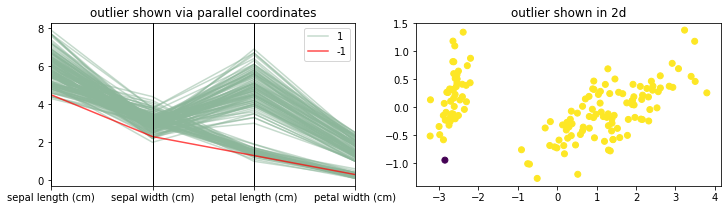

In [11]:
plot_model(PCAOutlierDetection, components=2, threshold=0.1)

### UMAP Demonstration

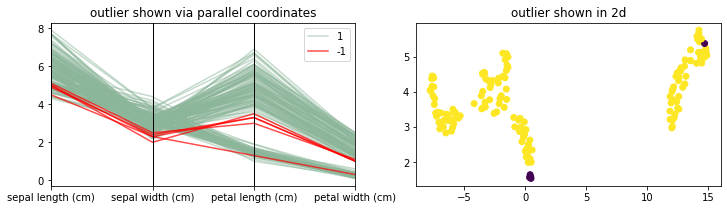

In [12]:
plot_model(UMAPOutlierDetection, components=2, threshold=0.2)

One thing to keep in mind here: UMAP is a lot slower.

### Interpretation of Hyperparams 

Both methods have a `n_components` and `threshold` parameter. The former tells the underlying transformer how many components to reduce to while the latter tells the model when to consider a reconstruction error "too big" for a datapoint not to be an outlier. If the relative error is larger than the set threshold it will be detected as an outlier. Typically that means that the threshold will be a lower value between 0.0-0.1. You can also specify an `absolute` threshold if that is preferable.

The other parameters in both models are unique to their underlying transformer method.

## Density Based Detection

We've also got a few outlier detection techniques that are density based approaches. You will find a subset documented [here](https://scikit-lego.readthedocs.io/en/latest/mixture-methods.html) but for completeness we will also list them below here as a comparison.

In [13]:
from sklego.mixture import GMMOutlierDetector, BayesianGMMOutlierDetector

### GMMOutlierDetector Demonstration

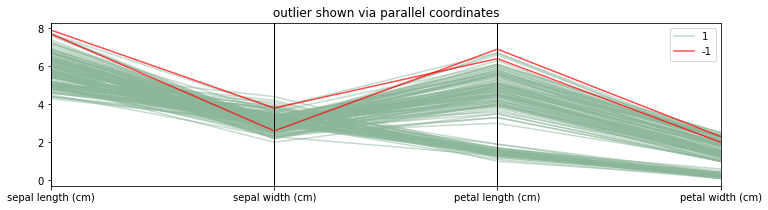

In [19]:
mod = GMMOutlierDetector(n_components=4, threshold=0.99).fit(X_orig)
X = X_orig.copy()
X['label'] = mod.predict(X)

plt.figure(figsize=(12, 3))
parallel_coordinates(X.loc[lambda d: d['label'] == 1], class_column='label', alpha=0.5)
parallel_coordinates(X.loc[lambda d: d['label'] == -1], class_column='label', color='red', alpha=0.7)
plt.title("outlier shown via parallel coordinates");

### BayesianGMMOutlierDetector Demonstration

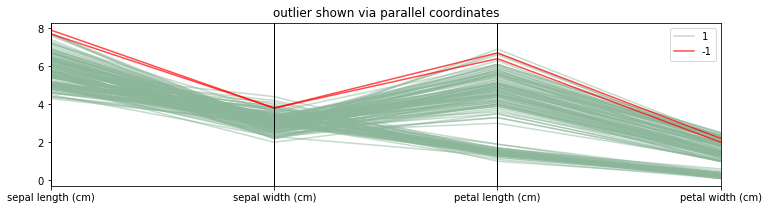

In [20]:
mod = BayesianGMMOutlierDetector(n_components=4, threshold=0.99).fit(X_orig)
X = X_orig.copy()
X['label'] = mod.predict(X)

plt.figure(figsize=(12, 3))
parallel_coordinates(X.loc[lambda d: d['label'] == 1], class_column='label', alpha=0.5)
parallel_coordinates(X.loc[lambda d: d['label'] == -1], class_column='label', color='red', alpha=0.7)
plt.title("outlier shown via parallel coordinates");

Note that for these density based approaches the threshold needs to be interpreted differently. If you're interested, you can find more information [here](https://scikit-lego.readthedocs.io/en/latest/mixture-methods.html#detection-details).

# Model Based Outlier Detection

Suppose that you've got an accurate model. Then you could argue that when a datapoint disagrees with your model that it might be an outlier. This library offers meta models that wrap estimators in order to become outlier detection models. 

## Regression Based 

If you have a regression model then we offer a `RegressionOutlierDetector`. This model takes the output of the regression model and compares it against the true regression labels. If the difference between the label and predicted value is larger than a threshold then we output an outlier flag. 

Note that in order to be complaint to the scikit-learn API we require that the `y`-label for the regression to be part of the `X` dataset.

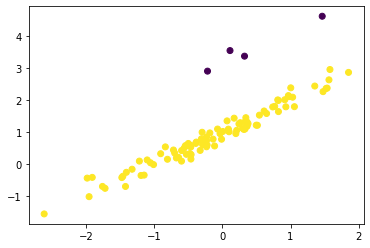

In [6]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklego.meta import RegressionOutlierDetector

# generate random data for illustrative example
np.random.seed(42)
X = np.random.normal(0, 1, (100, 1))
y = 1 + np.sum(X, axis=1).reshape(-1, 1) + np.random.normal(0, 0.2, (100, 1))
for i in [20, 25, 50, 80]:
    y[i] += 2
X = np.concatenate([X, y], axis=1)

# fit and plot
mod = RegressionOutlierDetector(LinearRegression(), column=1)
mod.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=mod.predict(X));